# **Laboratório 12**

Nome: Luiz Henrique da Silva Batista

NUSP: 

Curso: Ciências Sociais (Graduação - Noturno)

## **Objetivo**

Neste laboratório, o objetivo é classificar os tweets postados por elites políticas, durante 2020, quanto ao posicionamento (*stance*) adotado em relação às vacinas contra a Covid-19. Mais especificamente, estamos interessados em predizer corretamente a classe "desfavorável" (*unfavorable*), que indica um posiciomaneto contrário às vacinas. Assim, tweets que, por exemplo, criticam as vacinas, desincentivam a sua aplicação ou procuram enfatizar os efeitos negativos ao invés dos positivos, enquadram-se na classe "desfavorável".

# **1. Bibliotecas**

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import random
import nltk
import sklearn.model_selection as skm
import spacy
import unicodedata

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix
    )
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords

In [58]:
np.random.seed(123)
random.seed(123)

# **2. Importação dos dados**

In [59]:
dados = pd.read_csv('../Dados/tweets_2.0_2020.csv')
# dados = pd.read_csv('/content/tweets_2.0_2020.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet_id              3002 non-null   object
 1   content               3002 non-null   object
 2   Corrected_sentimento  1407 non-null   object
 3   Corrected_stance      1407 non-null   object
 4   Corrected_relevante   3002 non-null   object
 5   Corrected_children    1408 non-null   object
 6   round                 3002 non-null   int64 
 7   date_post             3002 non-null   object
 8   year                  3002 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 211.2+ KB


# **3. Pré-processamento**

### Renomeia colunas

In [60]:
dados = dados.rename(
    columns={'Corrected_sentimento':'sentiment',
             'Corrected_stance':'stance',
             'Corrected_relevante':'relevant',
             'Corrected_children':'children'}
    )

### Limpa texto

In [61]:
def text_processing(texto):
    # Converte tudo para minúsculo
    texto = texto.lower()
    # Remove URLs 'https://\S+'
    texto = re.sub(r'https://\S+', '', texto)
    # Remove hashtags '#(\w+)' -> \n
    texto = re.sub(r'#(\w+)', '', texto)
    # Remove quebra de linha
    texto = re.sub(r'\\n', ' ', texto)
    # Normaliza o texto para remover acentos e caracteres especiais
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
    # Seleciona apenas palavras com mais de duas letras
    texto = re.findall(r'\b[a-záàâãéêíóôõúç]{2,}\b', texto)
    # texto = re.findall('[a-z]+', texto)
    # Junta o texto, porque o .findall cria tokens
    texto = ' '.join(texto)

    return texto

dados['content_processed'] = dados['content'].apply(text_processing)
dados[['content', 'content_processed']]

,content,content_processed
0,A cabeça pensa onde o pé pisa. Quem governa de...,cabeca pensa onde pe pisa quem governa de dent...
1,Sarto vai fazer um grande Programa de Enfrenta...,sarto vai fazer um grande programa de enfrenta...
2,A Câmara dos Deputados votou hoje a MP que tra...,camara dos deputados votou hoje mp que trata d...
3,Tirar Bolsonaro do poder é uma questão de vida...,tirar bolsonaro do poder uma questao de vida o...
4,E a LIESA decidiu adiar os desfiles do #Carnav...,liesa decidiu adiar os desfiles do sem data na...
...,...,...
2997,"Boletim desta segunda-feira, 18 de maio. Tivem...",boletim desta segunda feira de maio tivemos ca...
2998,O que faz sentido ao que minha equipe epidemio...,que faz sentido ao que minha equipe epidemiolo...
2999,- @portalgp1 repercutiu o registro de nossa ca...,repercutiu registro de nossa candidatura alem ...
3000,Descriminalizar o aborto não é o mesmo que leg...,descriminalizar aborto nao mesmo que legalizar...


### Remove stopwords

In [62]:
# Baixar se não tiver baixado ainda
nltk.download('stopwords')
stop_words_pt = stopwords.words('portuguese')

def stopwords_remove(texto):
    palavras = texto.split()
    palavras = [palavra for palavra in palavras if palavra not in stop_words_pt]
    palavras = ' '.join(palavras)
    return palavras

dados['content_processed'] = dados['content_processed'].apply(stopwords_remove)
dados[['content', 'content_processed']]

[nltk_data] Downloading package stopwords to C:\Users\Luiz
[nltk_data]     Henrique/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,content_processed
0,A cabeça pensa onde o pé pisa. Quem governa de...,cabeca pensa onde pe pisa governa dentro escri...
1,Sarto vai fazer um grande Programa de Enfrenta...,sarto vai fazer grande programa enfrentamento ...
2,A Câmara dos Deputados votou hoje a MP que tra...,camara deputados votou hoje mp trata adesao br...
3,Tirar Bolsonaro do poder é uma questão de vida...,tirar bolsonaro poder questao vida morte presi...
4,E a LIESA decidiu adiar os desfiles do #Carnav...,liesa decidiu adiar desfiles data nao pensar s...
...,...,...
2997,"Boletim desta segunda-feira, 18 de maio. Tivem...",boletim desta segunda feira maio casos covid s...
2998,O que faz sentido ao que minha equipe epidemio...,faz sentido equipe epidemiologica sempre abord...
2999,- @portalgp1 repercutiu o registro de nossa ca...,repercutiu registro candidatura alem plano eme...
3000,Descriminalizar o aborto não é o mesmo que leg...,descriminalizar aborto nao legalizar deseja ga...


### Lematização

In [63]:
# !pip install spacy
# !python -m spacy download pt_core_news_sm

In [64]:
nlp = spacy.load("pt_core_news_sm")

# Função de pré-processamento com lematização
def lematization(texto):
    # Processar o texto com spaCy
    doc = nlp(texto)
    # Extrair apenas os lemas das palavras
    lemas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    # Juntar os lemas em uma única string
    return " ".join(lemas)

dados['content_processed'] = dados['content_processed'].apply(lematization)
dados[['content', 'content_processed']]

,content,content_processed
0,A cabeça pensa onde o pé pisa. Quem governa de...,cabeca pensar pe pisa governo escritorio ar co...
1,Sarto vai fazer um grande Programa de Enfrenta...,sarto programa enfrentamento pandemia garantir...
2,A Câmara dos Deputados votou hoje a MP que tra...,camar deputado votar hoje mp tratar adesao Bra...
3,Tirar Bolsonaro do poder é uma questão de vida...,tirar bolsonaro questao vida morte presidente ...
4,E a LIESA decidiu adiar os desfiles do #Carnav...,liesa decidir adiar desfile data nao pensar sa...
...,...,...
2997,"Boletim desta segunda-feira, 18 de maio. Tivem...",Boletim feira maio caso covid ser ja recuperar...
2998,O que faz sentido ao que minha equipe epidemio...,sentido equipe epidemiologico abordar geralmen...
2999,- @portalgp1 repercutiu o registro de nossa ca...,repercutir registro candidaturo aler plano eme...
3000,Descriminalizar o aborto não é o mesmo que leg...,descriminalizar aborto nao legalizar desejar g...


# **3. Análise Exploratória dos Dados**

In [65]:
# Filtra somente os dados com tweets relevantes, que é o que nos interessa
dados = dados[dados['relevant'] == 'relevant']

## Posicionamento

Text(0.5, 0, '')

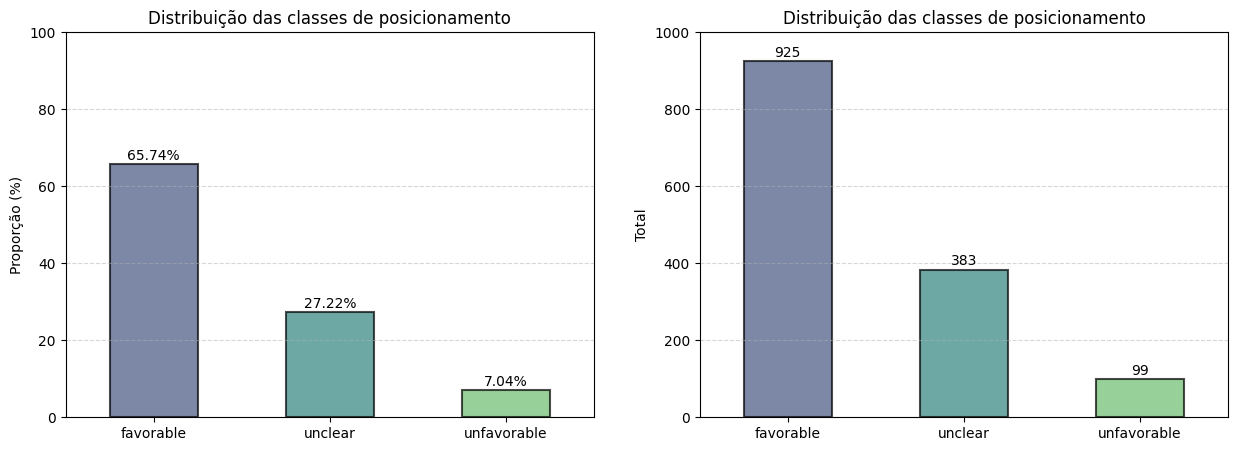

In [66]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)

ax = sns.countplot(
    data = dados,
    x = 'stance',
    stat = 'percent',
    hue = 'stance',
    palette = 'viridis',
    edgecolor = 'black',
    linewidth = 1.5,
    alpha = 0.7,
    width = 0.5
)

for container in ax.containers:
  ax.bar_label(
      container,
      labels = [f'{round(val, 2)}%' for val in container.datavalues],
      padding = 1
      )

plt.ylim(0,100)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Distribuição das classes de posicionamento')
plt.ylabel('Proporção (%)')
plt.xlabel('')


plt.subplot(1, 2, 2)

ax2 = sns.countplot(
    data = dados,
    x = 'stance',
    hue = 'stance',
    palette = 'viridis',
    edgecolor = 'black',
    linewidth = 1.5,
    alpha = 0.7,
    width = 0.5
)

for container in ax2.containers:
  ax2.bar_label(
      container,
      labels = [f'{int(val)}' for val in container.datavalues],
      padding = 1
      )

plt.ylim(0,1000)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Distribuição das classes de posicionamento')
plt.ylabel('Total')
plt.xlabel('')

## Nuvem de palavras

Vamos criar duas nuvens de palavras usando duas diferentes técnicas. A primeira delas consiste em visualizar simplesmente a frequência de ocorrência de cada palavra. A segunda detas consiste em usar o TF-IDF para visualizar a importância relativa de cada palavra

### Pela frequência

Separa *content* em textos favoráveis e unclear, de um lado, e desfavoráveis, de outro

In [67]:
textos_fav_unc = dados[(dados['stance'] == 'favorable') | (dados['stance'] == 'unclear')]['content_processed']
textos_desfav = dados[dados['stance'] == 'unfavorable']['content_processed']

Coloca tudo em uma string somente

In [68]:
textos_fav_unc = " ".join(textos_fav_unc)
textos_desfav = " ".join(textos_desfav)

Remove algumas variações da palavra "vacina", porque elas aparecem com mais frequência tanto entre os tweets favoráveis quanto entre os desfavoráveis e, portanto, ofuscam outras palavras.

In [69]:
textos_fav_unc = textos_fav_unc.replace(' vacina ', '')
textos_fav_unc = textos_fav_unc.replace(' vacino ', '')
textos_fav_unc = textos_fav_unc.replace(' vacinar ', '')

textos_desfav = textos_desfav.replace(' vacina ', '')
textos_desfav = textos_desfav.replace(' vacino ', '')
textos_desfav = textos_desfav.replace(' vacinar ', '')

Gera as nuvens de palavras

In [70]:
def gerar_nuvem(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, random_state=100, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=20)
    plt.show()

Tweets favoráveis

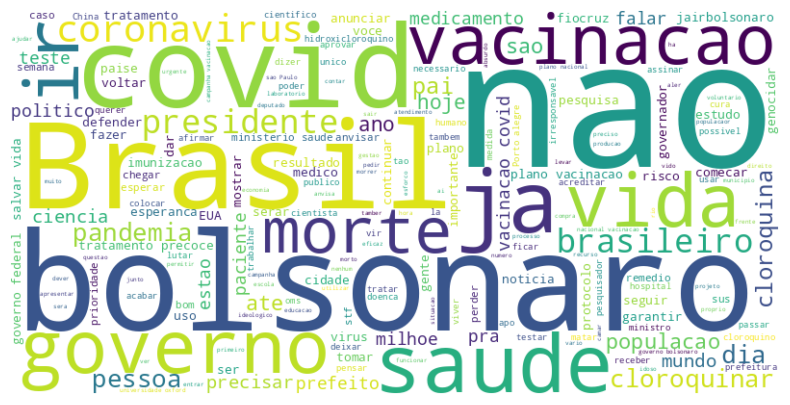

In [71]:
gerar_nuvem(textos_fav_unc, "")

Tweets desfavoráveis

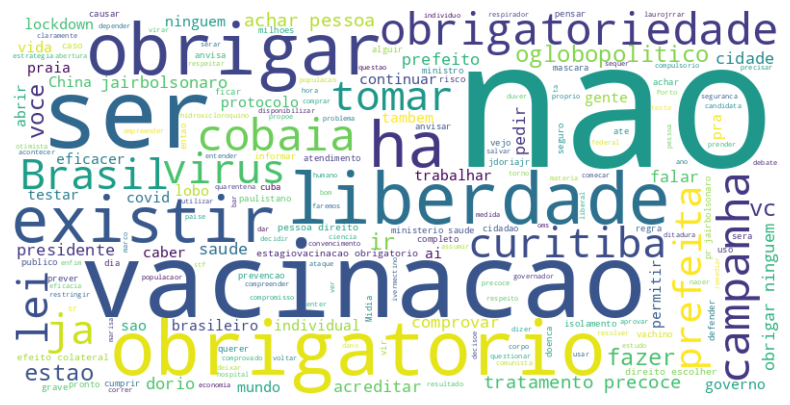

In [72]:
gerar_nuvem(textos_desfav, "")

### TF-IDF

Tweets favoráveis

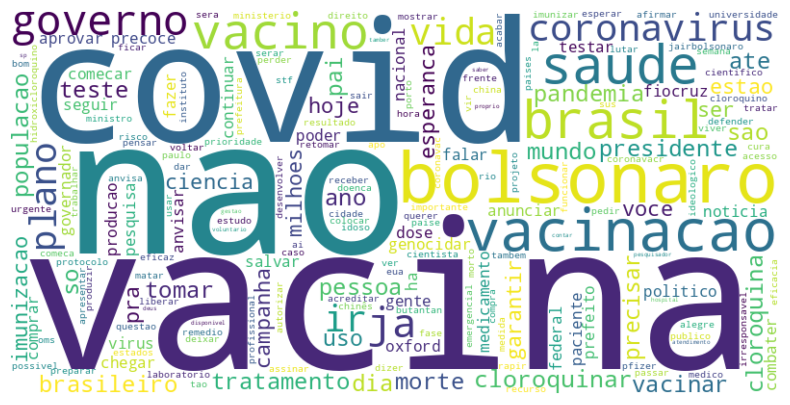

In [73]:
TF_IDF_vectorizer = TfidfVectorizer()

fav_unc = dados[(dados['stance'] == 'favorable') | (dados['stance'] == 'unclear')]
# fav_unc['content_processed'] = fav_unc['content_processed'].str.replace(' vacina ', ' ')
fav_unc = fav_unc['content_processed']

TF_IDF_fav_unc = TF_IDF_vectorizer.fit_transform(fav_unc)

words = TF_IDF_vectorizer.get_feature_names_out()

TF_IDF_values = TF_IDF_fav_unc.toarray()

mean_TF_IDF_values = np.mean(TF_IDF_values, axis=0)

df_TF_IDF = pd.DataFrame({"Word": words, "Mean_TF-IDF": mean_TF_IDF_values})

word_tfidf_dict = dict(zip(df_TF_IDF["Word"], df_TF_IDF["Mean_TF-IDF"]))

wordcloud = WordCloud(width=800, height=400, random_state=100,background_color='white').generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Tweets desfavoráveis

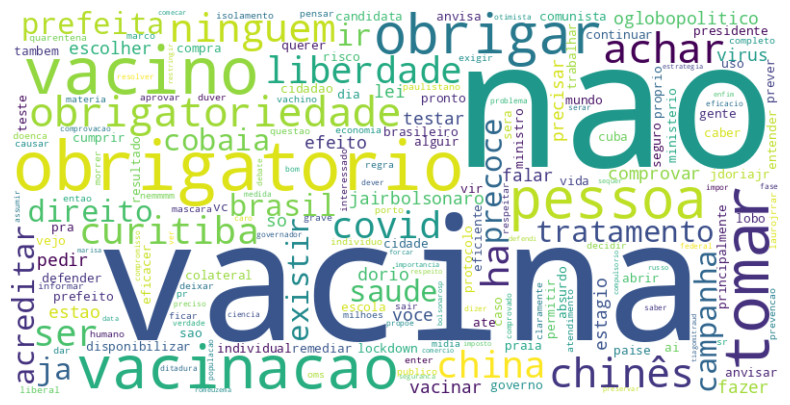

In [74]:
TF_IDF_vectorizer = TfidfVectorizer()

desfav = dados[(dados['stance'] == 'unfavorable')]
# desfav['content_processed'] = desfav['content_processed'].str.replace(' vacina ', ' ')
desfav = desfav['content_processed']

TF_IDF_desfav = TF_IDF_vectorizer.fit_transform(desfav)

words = TF_IDF_vectorizer.get_feature_names_out()

TF_IDF_values = TF_IDF_desfav.toarray()

mean_TF_IDF_values = np.mean(TF_IDF_values, axis=0)

df_TF_IDF = pd.DataFrame({"Word": words, "Mean_TF-IDF": mean_TF_IDF_values})

word_tfidf_dict = dict(zip(df_TF_IDF["Word"], df_TF_IDF["Mean_TF-IDF"]))

wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **4. Transformações**

### Label-Encoding

In [75]:
dados['stance_encoded'] = dados['stance'].map({'favorable':0, 'unclear':0, 'unfavorable':1})
dados['stance_encoded'].value_counts()

stance_encoded
0    1308
1      99
Name: count, dtype: int64

### Feature-Target-Split

In [76]:
features = dados['content_processed']
target = dados['stance_encoded']

### Train-Test-Split

In [77]:
x_treino, x_teste, y_treino, y_teste = train_test_split(
    features,
    target,
    test_size = 0.2,
    shuffle = True,
    stratify = target,
    random_state = 123
)

Text(0.5, 0, '')

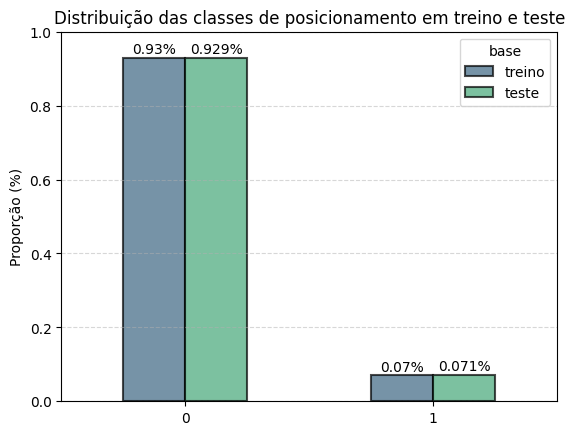

In [78]:
a = y_treino.copy()
a = pd.DataFrame(a)
a['base'] = 'treino'

b = y_teste.copy()
b = pd.DataFrame(b)
b['base'] = 'teste'

c = pd.concat([a, b])
d = c[['base', 'stance_encoded']].value_counts().reset_index()

d['proportion'] = d.groupby('base')['count'].transform(lambda x: x / sum(x))

ax = sns.barplot(
    data = d,
    x = 'stance_encoded',
    y = 'proportion',
    hue = 'base',
    palette = 'viridis',
    edgecolor = 'black',
    linewidth = 1.5,
    alpha = 0.7,
    width = 0.5
)

for container in ax.containers:
  ax.bar_label(
      container,
      labels = [f'{round(val, 3)}%' for val in container.datavalues],
      padding = 1
      )

plt.ylim(0,1)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.title('Distribuição das classes de posicionamento em treino e teste')
plt.ylabel('Proporção (%)')
plt.xlabel('')

### Vetorização: Bag of Words

In [79]:
# Vetorizador
vectorizer = CountVectorizer(
    stop_words = stop_words_pt,
    ngram_range = (1,1)
)

#### Features de treino

In [80]:
# Aplicando o Bow na base de treino
x_treino_bow = vectorizer.fit_transform(x_treino)
# Transforma em um data frame
x_treino_bow = pd.DataFrame(x_treino_bow.toarray())

#### Features de teste

In [81]:
# Aplica o BoW na base de teste
x_teste_bow = vectorizer.transform(x_teste)
# Transforma em um data frame
x_teste_bow = pd.DataFrame(x_teste_bow.toarray())

# **5. Baseline**

In [82]:
# Instancia o modelo de regressão logística
modelo_logistico = LogisticRegression()
# Ajustando o modelo
modelo_logistico.fit(x_treino_bow, y_treino)
# Prevendo no banco de teste
y_pred_logistico_baseline = modelo_logistico.predict(x_teste_bow)
# Métricas
print(f'Acurácia: {round(accuracy_score(y_teste, y_pred_logistico_baseline), 2)}')
print('')
print(f'Relatório de Classificação: \n{classification_report(y_teste, y_pred_logistico_baseline)}')

Acurácia: 0.95

Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       262
           1       1.00      0.35      0.52        20

    accuracy                           0.95       282
   macro avg       0.98      0.68      0.75       282
weighted avg       0.96      0.95      0.94       282



# **6. Modelos e Resultados**

### Parâmetros para cada modelo

In [83]:
# Modelo 1: Regressão Logística
param_grid_reg_log = {
    'C': [0.01, 0.1, 0.5, 1, 10],
    'solver': ['lbfgs', 'sag', 'saga'],
    'class_weight': ['balanced'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500, 1000]
}
# Modelo 2: Árvore de Decisão
param_grid_arvore = {
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
# Modelo 3: SVC
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced']
}
# Modelo 4: Naive Bayes
param_grid_naive_bayes = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10],
    'fit_prior': [True, False]
}
# Modelo 5: KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [5, 10, 20, 30],
}

### Random Search

In [84]:
random_reg_log = RandomizedSearchCV(
    LogisticRegression(random_state=123),
    param_distributions=param_grid_reg_log,
    cv=10,
    scoring='recall',
    n_jobs=-1
)
random_arvore = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=123),
    param_distributions=param_grid_arvore,
    cv=10,
    scoring='recall',
    n_jobs=-1
)
random_SVC = RandomizedSearchCV(
    SVC(random_state=123, probability=True),
    param_distributions=param_grid_svc,
    cv=10,
    scoring='recall',
    n_jobs=-1
)
random_naive_bayes = RandomizedSearchCV(
    MultinomialNB(),
    param_distributions=param_grid_naive_bayes,
    cv=10,
    scoring='recall',
    n_jobs=-1
)
random_knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_grid_knn,
    n_iter=50,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    random_state=123
)

### Treinamento

In [85]:
# Desativa warnings
import warnings
warnings.filterwarnings('ignore')

In [86]:
random_reg_log.fit(x_treino_bow, y_treino)
random_arvore.fit(x_treino_bow, y_treino)
random_SVC.fit(x_treino_bow, y_treino)
random_naive_bayes.fit(x_treino_bow, y_treino)
random_knn.fit(x_treino_bow, y_treino)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [5, 10, 20, 30],
                                        'n_neighbors': [3, 5, 7, 10, 15],
                                        'weights': ['uniform', 'distance']},
                   random_state=123, scoring='recall')

### Melhores estimadores

In [96]:
best_reg_log = random_reg_log.best_estimator_
best_arvore = random_arvore.best_estimator_
best_svc = random_SVC.best_estimator_
best_naive_bayes = random_naive_bayes.best_estimator_
best_knn = random_knn.best_estimator_

In [97]:
print(f'Regressão Logística: {random_reg_log.best_params_}')
print(f'Árvore de Decisão: {random_arvore.best_params_}')
print(f'SVC: {random_SVC.best_params_}')
print(f'Multinomial Naive Bayes: {random_naive_bayes.best_params_}')
print(f'KNN: {random_knn.best_params_}')

Regressão Logística: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'class_weight': 'balanced', 'C': 0.5}
Árvore de Decisão: {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
SVC: {'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'class_weight': 'balanced', 'C': 1}
Multinomial Naive Bayes: {'fit_prior': False, 'alpha': 0.1}
KNN: {'weights': 'distance', 'n_neighbors': 3, 'leaf_size': 30, 'algorithm': 'auto'}


### K-Fold Cross Validation

In [98]:
# Definição do número de folds
kf = skm.KFold(
    n_splits=10,
    shuffle=True,
    random_state=123
)

# Definição dos folds
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
    print(f'Fold: {i}')
    print(f'  Treino: tamanho = {len(train_index)}')
    print(f'  Teste: tamanho = {len(test_index)}')

Fold: 0
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 1
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 2
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 3
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 4
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 5
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 6
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 7
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 8
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 9
  Treino: tamanho = 1013
  Teste: tamanho = 112


In [112]:
# Ajuste dos inputs
y_treino_array = y_treino.to_numpy()

# Modelos a serem testados
modelos = {
    'Regressão Logística (baseline)': LogisticRegression(),
    'Regressão Logística': best_reg_log,
    'Árvore de Decisão': best_arvore,
    'SVC': best_svc,
    'Multinomial Naive Bayes': best_naive_bayes,
    'KNN': best_knn
}

resultados = []

# Loop de treinamento
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
    # Separação entre treino e validacao
    x_treino_kf, x_validacao_kf = x_treino.iloc[train_index], x_treino.iloc[test_index]
    y_treino_kf, y_validacao_kf = y_treino_array[train_index], y_treino_array[test_index]
    # Aplica o vetorizador
    x_treino_kf_bow = vectorizer.fit_transform(x_treino_kf)
    x_validacao_kf_bow = vectorizer.transform(x_validacao_kf)
    # Treinamento dos modelos
    for nome_modelo, modelo in modelos.items():
        # Treinamento do modelo
        modelo.fit(x_treino_kf_bow, y_treino_kf)
        # Previsões
        y_pred = modelo.predict(x_validacao_kf_bow)
        # Calculando as métricas
        precision, recall, f1, suporte = precision_recall_fscore_support(
            y_validacao_kf,
            y_pred,
            average=None,
            labels=[0, 1],
            zero_division=True
        )
        # Armazenando os resultados no DataFrame
        metricas_dicio = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'suporte': suporte,
            'fold': i,
            'modelo': nome_modelo
        }
        # Cria um DataFrame a partir do dicionário e acumula os resultados
        metricas_df = pd.DataFrame(metricas_dicio)
        # Converte o index em uma coluna
        metricas_df.reset_index(inplace=True)
        # Renomeia a coluna
        metricas_df = metricas_df.rename(columns={'index':'classe'})
        # Armazena na lista
        resultados.append(metricas_df)

# Junta tudo
resultados = pd.concat(resultados, axis=0)

# Exibe o DataFrame com as métricas de todos os modelos e folds
resultados.reset_index(drop=True, inplace=True)

In [101]:
resultados['classe'] = resultados['classe'].map({0:'favorável + unclear', 1:'desfavorável'})
resultados.reset_index(drop=True, inplace=True)

In [102]:
resultados

,classe,precision,recall,f1,suporte,fold,modelo
0,favorável + unclear,0.955357,1.000000,0.977169,107,0,Regressão Logística (baseline)
1,desfavorável,1.000000,0.166667,0.285714,6,0,Regressão Logística (baseline)
2,favorável + unclear,0.990476,0.971963,0.981132,107,0,Regressão Logística
3,desfavorável,0.625000,0.833333,0.714286,6,0,Regressão Logística
4,favorável + unclear,0.971698,0.962617,0.967136,107,0,Árvore de Decisão
...,...,...,...,...,...,...,...
115,desfavorável,1.000000,0.000000,0.000000,8,9,SVC
116,favorável + unclear,0.962617,0.990385,0.976303,104,9,Multinomial Naive Bayes
117,desfavorável,0.800000,0.500000,0.615385,8,9,Multinomial Naive Bayes
118,favorável + unclear,0.936937,1.000000,0.967442,104,9,Gradient Boosting


Text(0.5, 0, '')

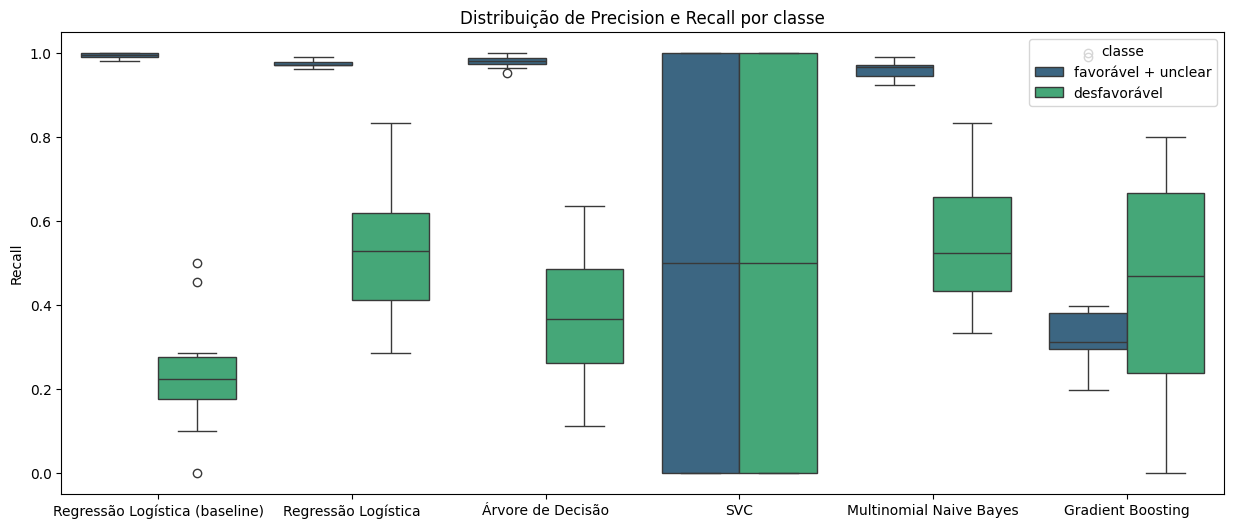

In [104]:
plt.figure(figsize=(15,6))

sns.boxplot(
    x='modelo', 
    y='recall', 
    hue='classe', 
    data=resultados, 
    palette='viridis'
)

plt.title('Distribuição de Precision e Recall por classe')
plt.ylabel('Recall')
plt.xlabel('')

Text(992.81045751634, 0.5, '')

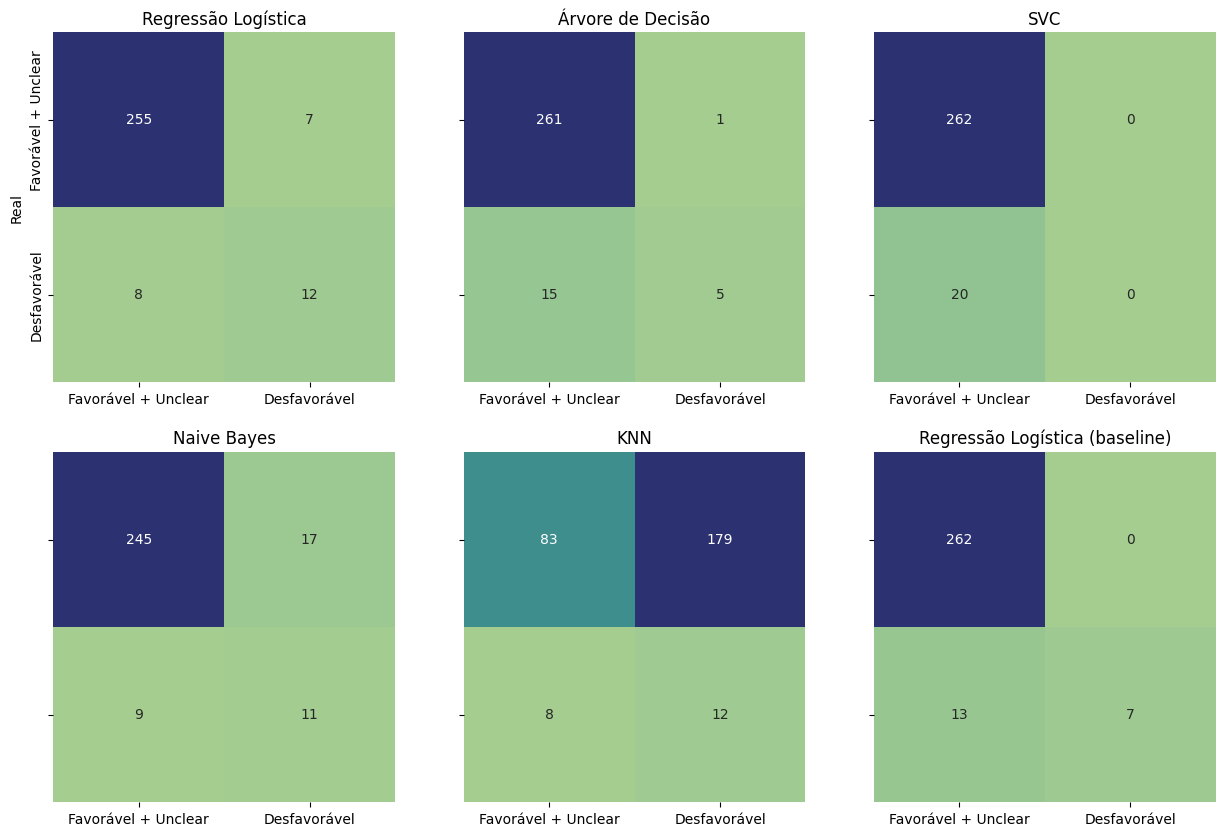

In [111]:
from sklearn.metrics import confusion_matrix

best_reg_log.fit(x_treino_bow, y_treino)
y_pred1 = best_reg_log.predict(x_teste_bow)

best_arvore.fit(x_treino_bow, y_treino)
y_pred2 = best_arvore.predict(x_teste_bow)

best_svc.fit(x_treino_bow, y_treino)
y_pred3 = best_svc.predict(x_teste_bow)

best_naive_bayes.fit(x_treino_bow, y_treino)
y_pred4 = best_naive_bayes.predict(x_teste_bow)

best_knn.fit(x_treino_bow, y_treino)
y_pred5 = best_knn.predict(x_teste_bow)

modelo_logistico.fit(x_treino_bow, y_treino)
y_pred6 = modelo_logistico.predict(x_teste_bow)

# Plotando o gráfico de mapa de calor para a matriz combinada
plt.figure(figsize=(15, 10))

### Modelo de Regressão Logística
plt.subplot(2, 3, 1)
sns.heatmap(
    confusion_matrix(y_teste, y_pred1),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['Favorável + Unclear', 'Desfavorável'],
    cbar=False
    )

plt.title("Regressão Logística")
plt.xlabel("")
plt.ylabel("Real")


### Modelo de Árvore de Decisão
plt.subplot(2, 3, 2)
sns.heatmap(
    confusion_matrix(y_teste, y_pred2),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
    )

plt.title("Árvore de Decisão")
plt.xlabel("")
plt.ylabel("")

### Modelo SVC
plt.subplot(2, 3, 3)
sns.heatmap(
    confusion_matrix(y_teste, y_pred3),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("SVC")
plt.xlabel("")
plt.ylabel("")

### Modelo Naive Bayes
plt.subplot(2, 3, 4)
sns.heatmap(
    confusion_matrix(y_teste, y_pred4),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("Naive Bayes")
plt.xlabel("")
plt.ylabel("")

### Modelo best_knn
plt.subplot(2, 3, 5)
sns.heatmap(
    confusion_matrix(y_teste, y_pred5),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("KNN")
plt.xlabel("")
plt.ylabel("")

### Modelo de Regressão Logística (baseline)
plt.subplot(2, 3, 6)
sns.heatmap(
    confusion_matrix(y_teste, y_pred6),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("Regressão Logística (baseline)")
plt.xlabel("")
plt.ylabel("")